<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [195]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 99% 118M/119M [00:06<00:00, 23.8MB/s]
100% 119M/119M [00:06<00:00, 19.4MB/s]


## Preprocesamiento de datos



In [182]:
#Homogenizar los nombres de carpetas

# !mv Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/train/adenocarcinoma

# !mv Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/train/large.cell.carcinoma

# !mv Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/train/squamous.cell.carcinoma

# !mv Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/valid/adenocarcinoma

# !mv Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/valid/large.cell.carcinoma

# !mv Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/valid/squamous.cell.carcinoma

In [196]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [197]:
input_size = (224, 224)

training_datagen = ImageDataGenerator(
    rescale=1./255,
      rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=64,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=64,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=64,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [218]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [231]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes, activation='softmax'))

In [232]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 100
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    )



Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 0.9527 - accuracy: 0.5971 - val_loss: 0.9983 - val_accuracy: 0.4722
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 0.9189 - accuracy: 0.5742 - val_loss: 0.9759 - val_accuracy: 0.4583
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.9071 - accuracy: 0.6036 - val_loss: 0.9589 - val_accuracy: 0.5417
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.9253 - accuracy: 0.6020 - val_loss: 0.9680 - val_accuracy: 0.5000
Epoch 5/100
10/10 [==============================] - 14s 1s/step - loss: 0.9456 - accuracy: 0.5808 - val_loss: 0.9600 - val_accuracy: 0.4861
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.8956 - accuracy: 0.6020 - val_loss: 0.9546 - val_accuracy: 0.5139
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.8747 - accuracy: 0.6134 - val_loss: 0.9204 - val_accuracy: 0.5833
Epoch 8/100
1

In [ ]:
model.summary()

In [224]:
model.evaluate(test_generator)

5/5 [==============================] - 5s 1s/step - loss: 0.8562 - accuracy: 0.5841


[0.8562036156654358, 0.5841270089149475]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

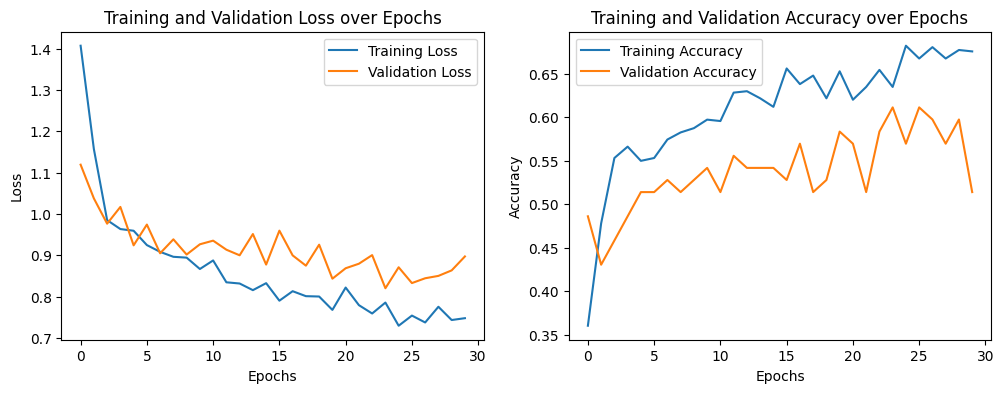

In [225]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

5/5 [==============================] - 3s 408ms/step


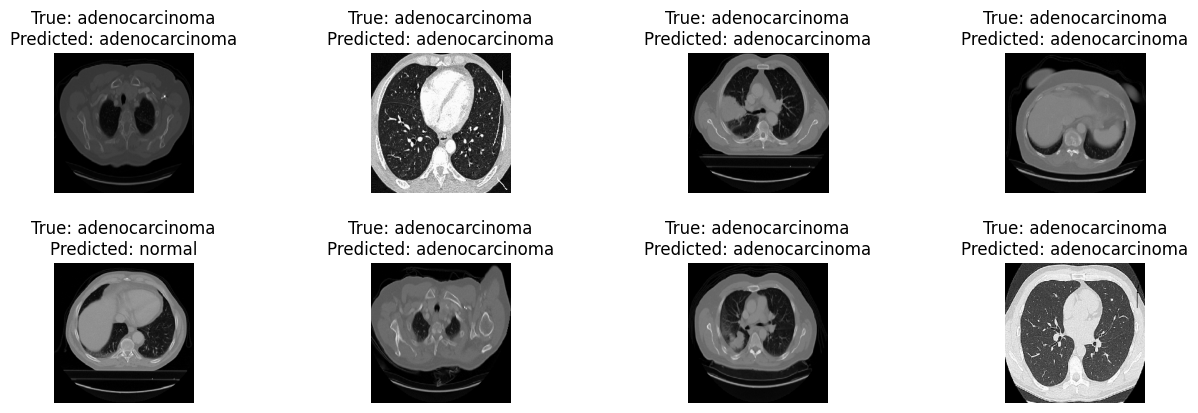

In [226]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[79  0 31 10]
 [36  1  6  8]
 [38  3  9  4]
 [67  3 12  8]]


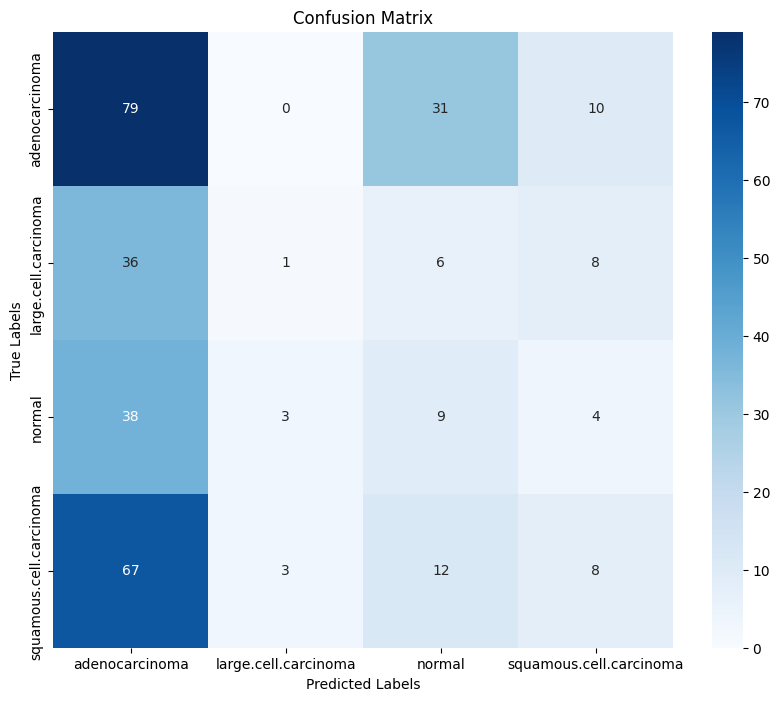

In [227]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()